# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [331]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [332]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [333]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("Number of rows: ", len(azdias))
print("Number of columns: ", len(azdias.columns))
azdias.head()

Number of rows:  891221
Number of columns:  85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [334]:
# Identify missing or unknown data values and convert them to NaNs.
def parse_unknown_marker(x: str) -> list:
    """
    Parses a string representation of a list and converts it into a list of integers.

    Args:
        x (str): The string representation of a list.

    Returns:
        list: A list of integers.

    """
    x = x.replace('[', '').replace(']', '').split(',')
    for i in range(len(x)):
        try:
            x[i] = int(x[i])
        except:
            pass
    return x

feat_info.missing_or_unknown = feat_info.missing_or_unknown.apply(parse_unknown_marker)

In [335]:
for attribute, _, _, missing_or_unknown in feat_info.values:
    azdias[attribute] = azdias[attribute].apply(lambda x: np.nan if x in missing_or_unknown else x)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [336]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

azdias.isna().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

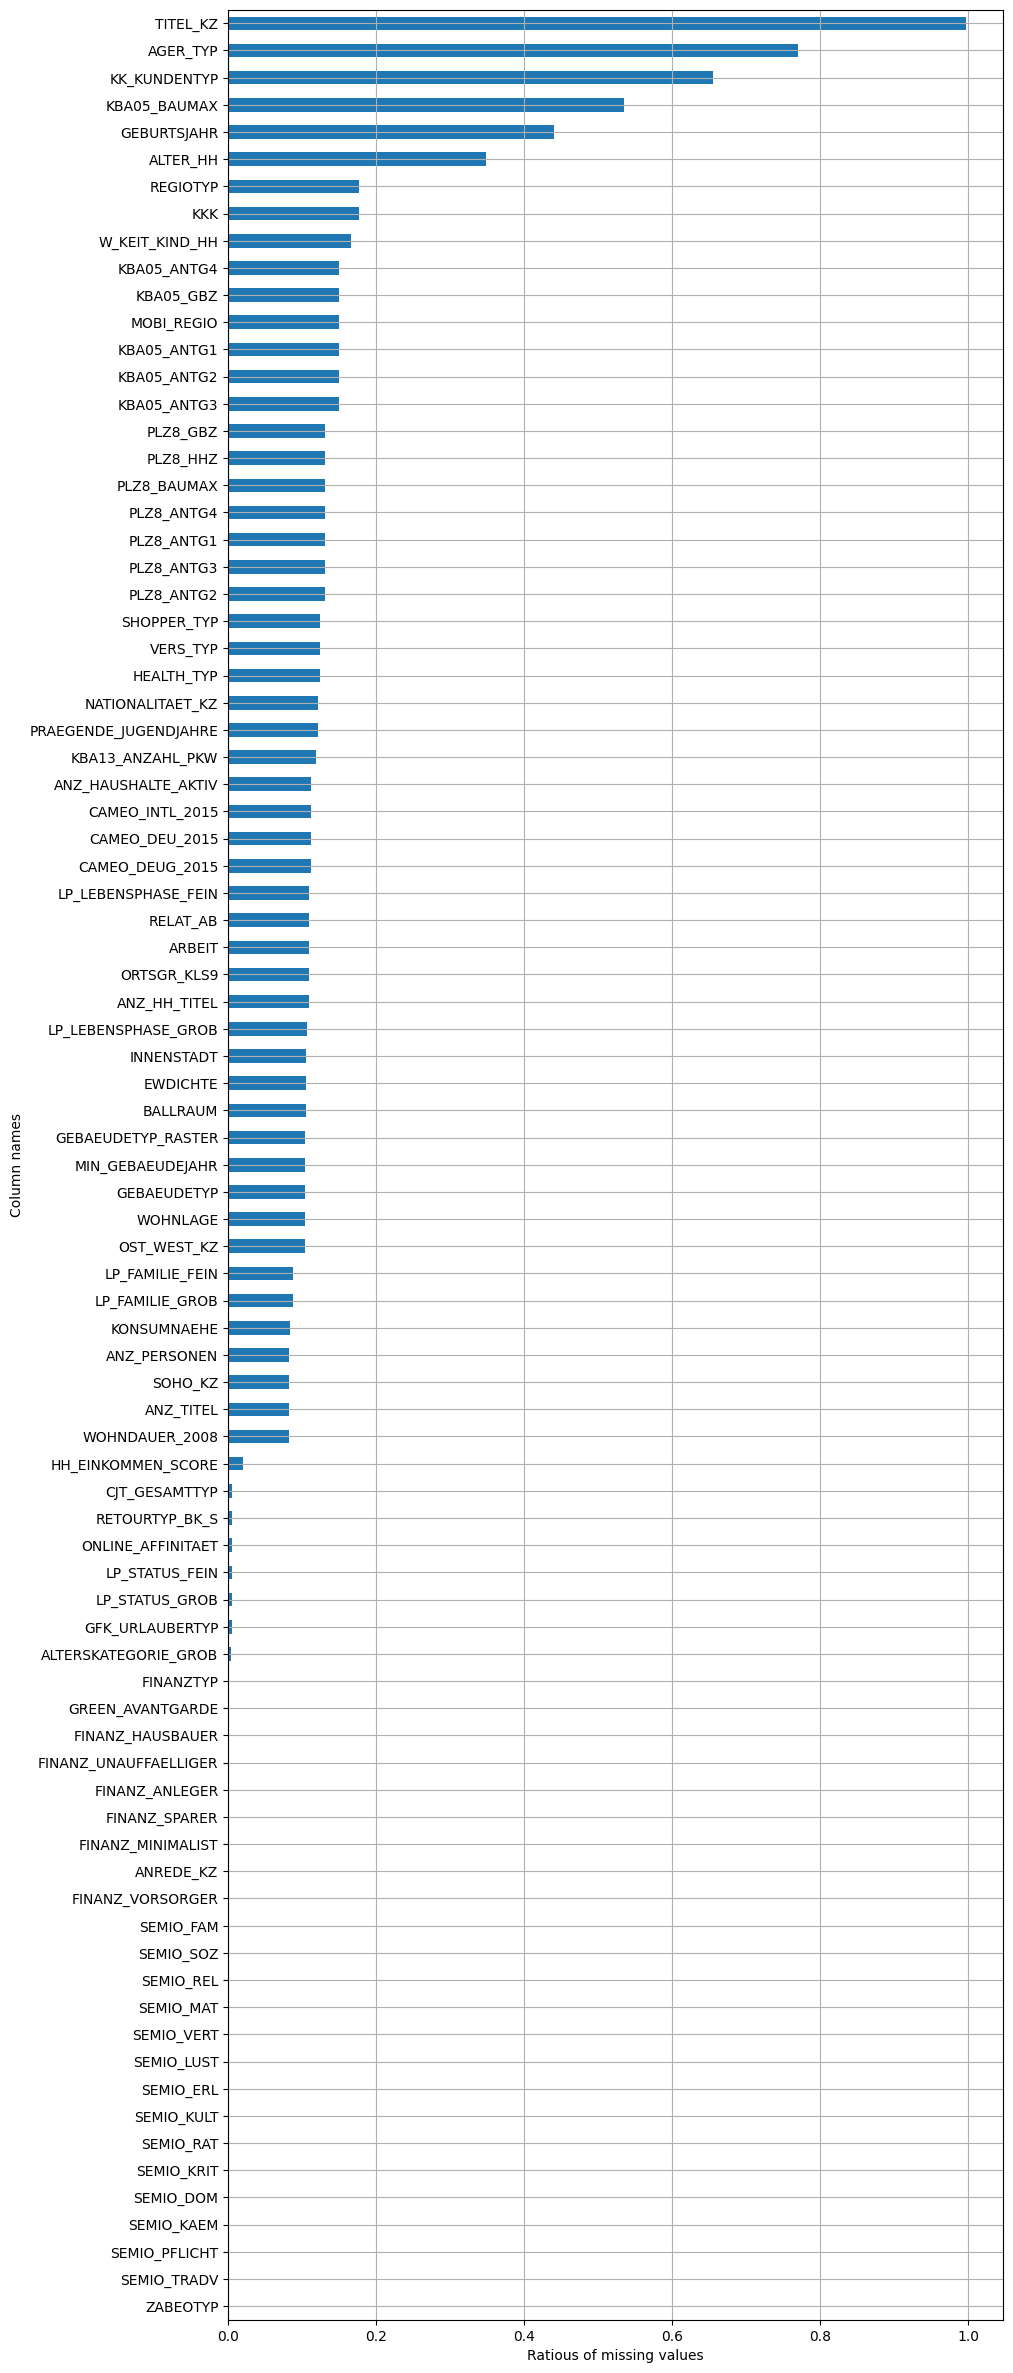

In [337]:
# Investigate patterns in the amount of missing data in each column.

(azdias.isna().sum().sort_values(ascending=True) / len(azdias)).plot.barh(figsize=(10, 30), grid=True)
plt.xlabel('Ratious of missing values')
plt.ylabel('Column names')
plt.show()

In [338]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

missing_count = azdias.isna().sum()
azdias = azdias.drop(columns=missing_count[missing_count > 200000].index, axis='columns')

#### Discussion 1.1.2: Assess Missing Data in Each Column

Among the dataset's columns, TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, and ALTER_HH exhibit a higher prevalence of missing values compared to others. Notably, TITEL_KZ, AGER_TYP, KK_KUNDENTYP, and KBA05_BAUMAX are devoid of data in over half of all samples, while TITEL_KZ lacks values in almost all instances. Consequently, these columns were excluded from the dataset.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

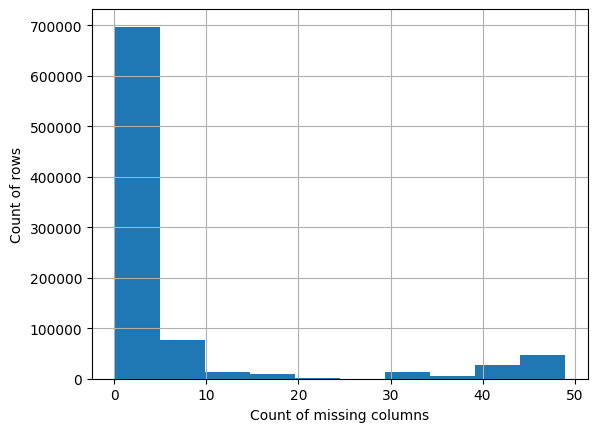

In [339]:
# How much data is missing in each row of the dataset?

missing_count_in_row = azdias.isna().sum(axis=1)
missing_count_in_row.hist()
plt.xlabel('Count of missing columns')
plt.ylabel('Count of rows')
plt.show()

In [340]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

missing_above_25 = azdias.loc[missing_count_in_row >= 25]
missing_below_25 = azdias.loc[missing_count_in_row < 25]

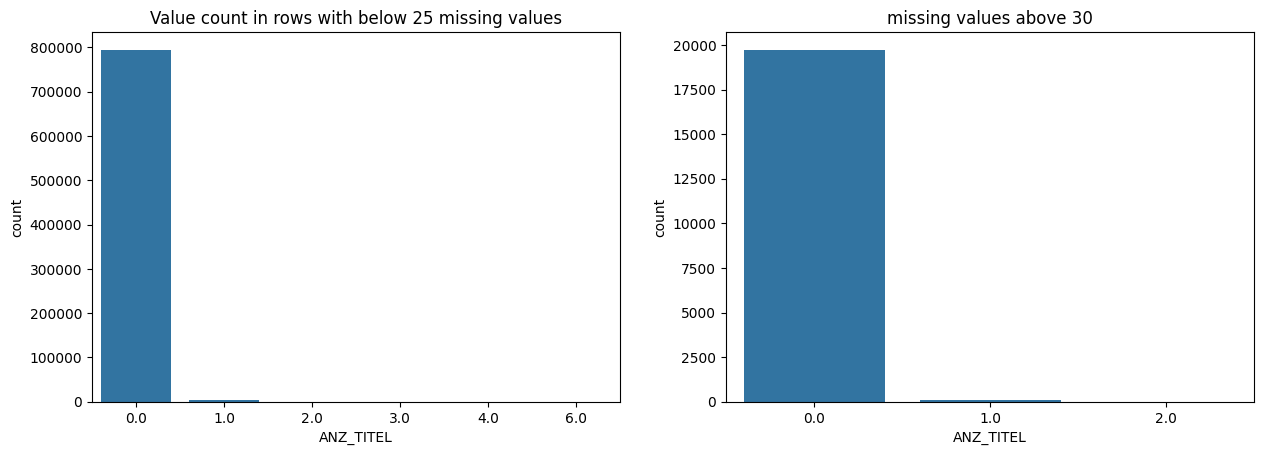

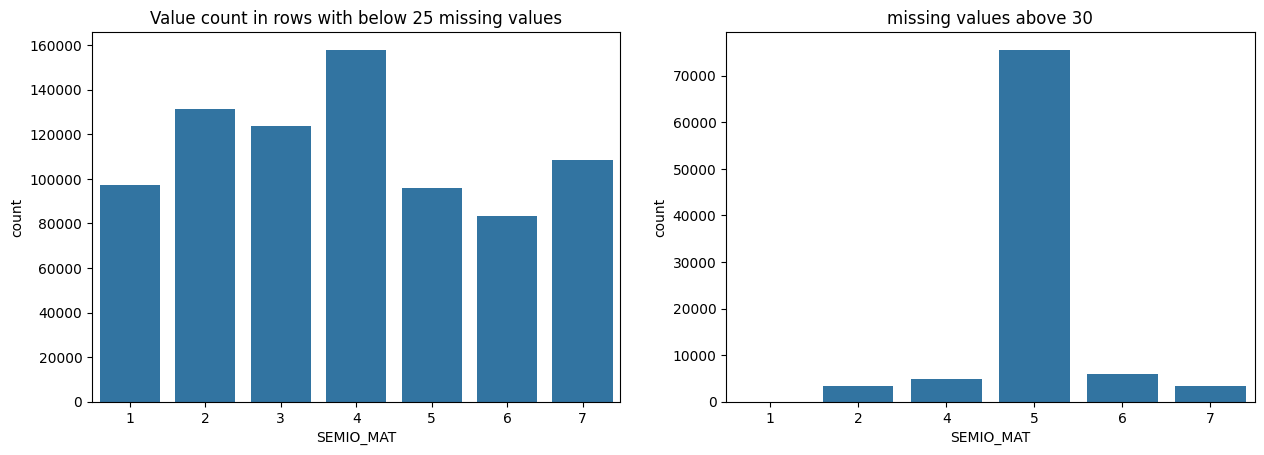

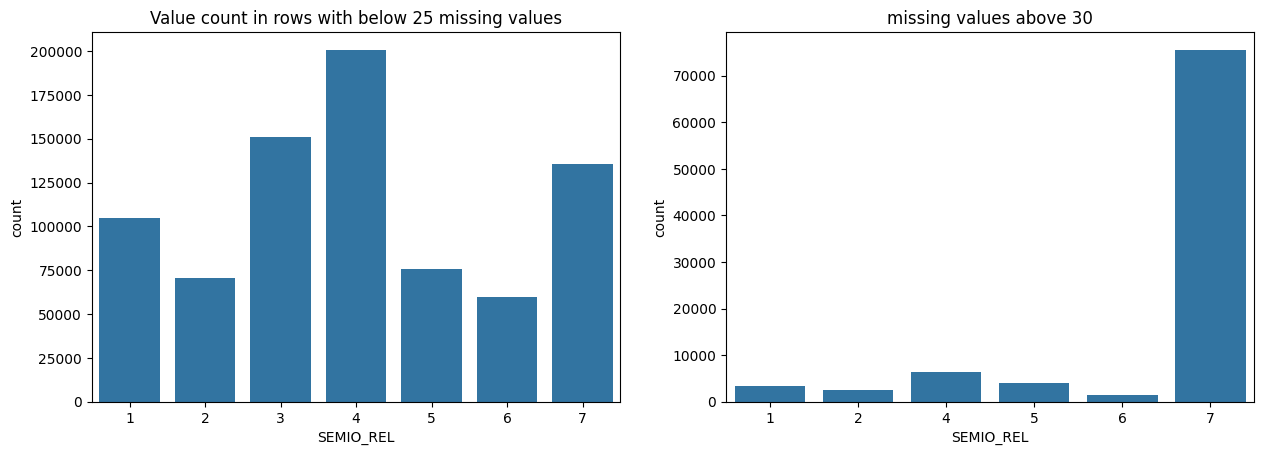

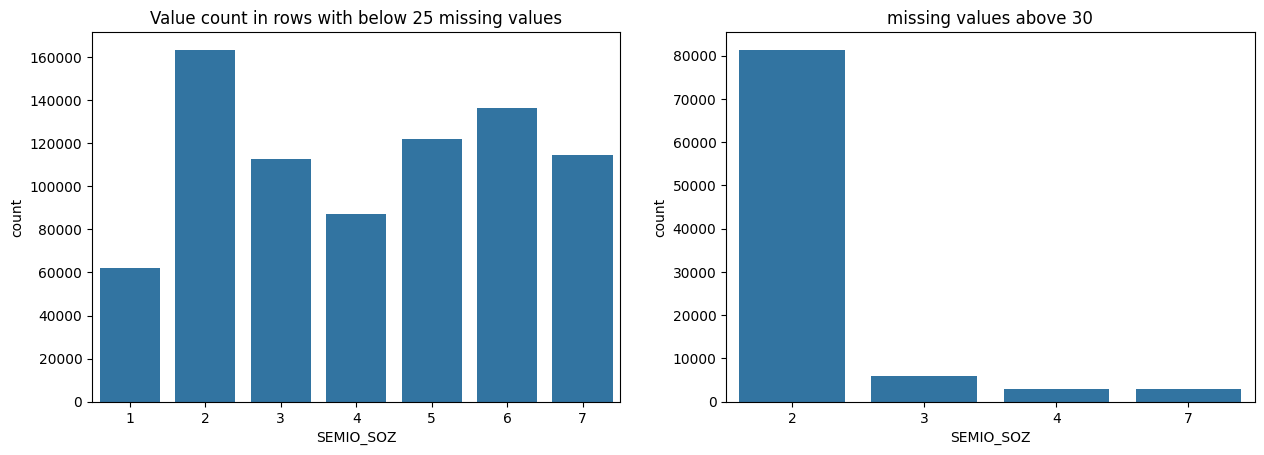

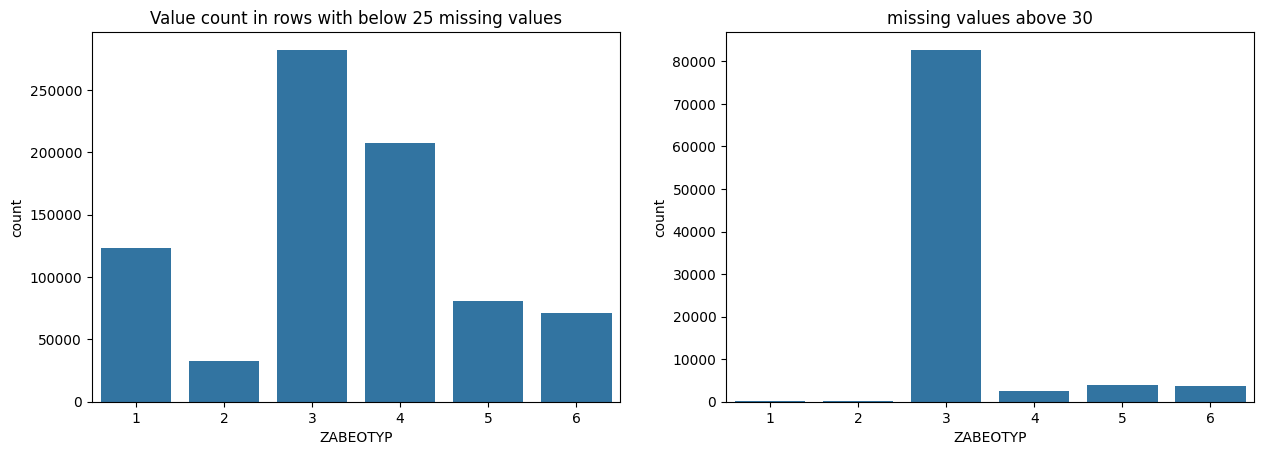

In [341]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

few_missing_cols_above_25 = missing_above_25.isnull().sum().sort_values(ascending=True).head(3)
few_missing_cols_below_25 = missing_below_25.isnull().sum().sort_values(ascending=True).head(3)
few_missing_cols = few_missing_cols_above_25.index.union(few_missing_cols_below_25.index)

for col in few_missing_cols:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title('Value count in rows with below 25 missing values')
    sns.countplot(x=missing_below_25.loc[:, col], ax=ax1)

    ax2.set_title('missing values above 30')
    sns.countplot(x=missing_above_25.loc[:, col], ax=ax2)
    
    plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

Samples with 25 or fewer missing columns show a wide range of distribution characteristics for all possible values, while samples with more than 25 missing columns show a distribution that is heavily skewed toward certain single value. These two groups require different approaches. For now, to keep things simple, we'll only focus on samples with fewer than 25 missing observations.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [342]:
# How many features are there of each data type?

feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [343]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

category_columns = feat_info[feat_info.type == 'categorical'].attribute
category_columns = category_columns[category_columns.isin(missing_below_25.columns)]

for col in category_columns:
    print(col, missing_below_25[col].nunique())
    print(missing_below_25[col].value_counts())

ANREDE_KZ 2
2    416089
1    381817
Name: ANREDE_KZ, dtype: int64
CJT_GESAMTTYP 6
4.0    198280
3.0    147203
2.0    141260
5.0    111104
6.0    102075
1.0     93306
Name: CJT_GESAMTTYP, dtype: int64
FINANZTYP 6
6    289047
1    197117
5    106321
2    104748
4     55916
3     44757
Name: FINANZTYP, dtype: int64
GFK_URLAUBERTYP 12
12.0    130235
10.0    102823
8.0      83028
11.0     75099
5.0      70498
4.0      60422
9.0      57124
3.0      53101
1.0      50656
2.0      43826
7.0      40678
6.0      25738
Name: GFK_URLAUBERTYP, dtype: int64
GREEN_AVANTGARDE 2
0    622698
1    175208
Name: GREEN_AVANTGARDE, dtype: int64
LP_FAMILIE_FEIN 11
1.0     402538
10.0    128966
2.0      98548
11.0     48744
8.0      21780
7.0      19575
4.0      11574
5.0      11167
9.0      10452
6.0       8526
3.0       4688
Name: LP_FAMILIE_FEIN, dtype: int64
LP_FAMILIE_GROB 5
1.0    402538
5.0    188162
2.0     98548
4.0     49881
3.0     27429
Name: LP_FAMILIE_GROB, dtype: int64
LP_STATUS_FEIN 10
1.0     2

In [344]:
# Re-encode categorical variable(s) to be kept in the analysis.
from sklearn.preprocessing import OneHotEncoder

non_numeric_cat_col = list(filter(lambda x: missing_below_25[x].dtype == 'object', category_columns))

# create OneHotEncoder object
encoder = OneHotEncoder()

# fit and transform color column
one_hot_array = encoder.fit_transform(missing_below_25[non_numeric_cat_col]).toarray()

# create new dataframe from numpy array
one_hot_df = pd.DataFrame(one_hot_array, columns = encoder.get_feature_names_out(), index = missing_below_25.index)

#concat with df
azdias = pd.concat([missing_below_25, one_hot_df], axis=1).drop(non_numeric_cat_col, axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

Among the 21 categorical columns, three of them, namely 'OST_WEST_KZ', 'CAMEO_DEUG_2015', and 'CAMEO_DEU_2015', contain non-numerical values. To handle this, perform one-hot encoding on these columns to convert them into dummy variables with numeric values. Subsequently, remove the original columns to streamline the dataset.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [345]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias['DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].replace({1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90})
azdias['MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].replace({1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1})
azdias = azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

In [346]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[0]) if pd.notnull(x) else x)
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[1]) if pd.notnull(x) else x)
azdias = azdias.drop('CAMEO_INTL_2015', axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I extracted DECADE and MOVEMENT from the PRAEGENDE_JUGENDJAHRE column and created a new column for them. Similarly, I extracted WEALTH and LIFE_STAGE from the CAMEO_INTL_2015 column and created another new column. The original columns were removed to prevent redundancy with the newly created ones.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [347]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

print("Number of rows: ", len(azdias))
print("Number of columns: ", len(azdias.columns))
azdias.head()

Number of rows:  797906
Number of columns:  135


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_nan,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_nan,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,5.0,1.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,1.0,2.0,4.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,1.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0

In [348]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [349]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the given dataframe by executing the main cleaning steps:
    - Convert missing value codes into NaNs.
    - Remove selected columns and rows.
    - Select, re-encode, and engineer column values.
    
    Args:
        df (pd.DataFrame): The dataframe to be cleaned.
        
    Returns:
        pd.DataFrame: The cleaned dataframe.
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for attribute, _, _, missing_or_unknown in feat_info.values:
        df[attribute] = df[attribute].apply(lambda x: np.nan if x in missing_or_unknown else x)
    
    # remove selected columns and rows, ...
    columns_to_remove = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(columns=columns_to_remove, axis='columns')

    missing_count_in_row = df.isna().sum(axis=1)
    df = df.loc[missing_count_in_row < 25]
    
    # select, re-encode, and engineer column values.
    category_columns = feat_info[feat_info.type == 'categorical'].attribute
    category_columns = category_columns[category_columns.isin(df.columns)]

    non_numeric_cat_col = list(filter(lambda x: df[x].dtype == 'object', category_columns))
    encoder = OneHotEncoder()
    one_hot_array = encoder.fit_transform(df[non_numeric_cat_col]).toarray()
    one_hot_df = pd.DataFrame(one_hot_array, columns = encoder.get_feature_names_out(), index = df.index)
    df = pd.concat([df, one_hot_df], axis=1).drop(non_numeric_cat_col, axis=1)

    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].replace({1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90})
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].replace({1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1})
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[0]) if pd.notnull(x) else x)
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[1]) if pd.notnull(x) else x)
    df = df.drop('CAMEO_INTL_2015', axis=1)

    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [350]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias.isna().sum()

ALTERSKATEGORIE_GROB      2800
ANREDE_KZ                    0
CJT_GESAMTTYP             4678
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
FINANZTYP                    0
GFK_URLAUBERTYP           4678
GREEN_AVANTGARDE             0
HEALTH_TYP               36671
LP_LEBENSPHASE_FEIN      50078
LP_LEBENSPHASE_GROB      47195
LP_FAMILIE_FEIN          31348
LP_FAMILIE_GROB          31348
LP_STATUS_FEIN            4678
LP_STATUS_GROB            4678
NATIONALITAET_KZ         33871
RETOURTYP_BK_S            4678
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KA

In [351]:
azdias = azdias.dropna()

In [352]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_array = scaler.fit_transform(azdias)

azdias = pd.DataFrame(scaled_array, columns = azdias.columns, index = azdias.index)

### Discussion 2.1: Apply Feature Scaling

Given that the number of samples containing NaNs is relatively low compared to the total dataset, we opted to eliminate all samples with NaNs. Subsequently, we standardized each column by subtracting its mean and scaling it to have a unit variance.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [353]:
# Apply PCA to the data.

from sklearn.decomposition import PCA

def do_pca(n_components: int, data: pd.DataFrame) -> (PCA, np.array):
    """
    Perform Principal Component Analysis (PCA) on the given data.

    Parameters:
    n_components (int): The number of components to keep.
    data (pd.DataFrame): The input data.

    Returns:
    pca (PCA): The fitted PCA object.
    X_pca (np.array): The transformed data.
    """

    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca


components = 2 * len(azdias.columns) // 3
pca, X_pca = do_pca(components, azdias)

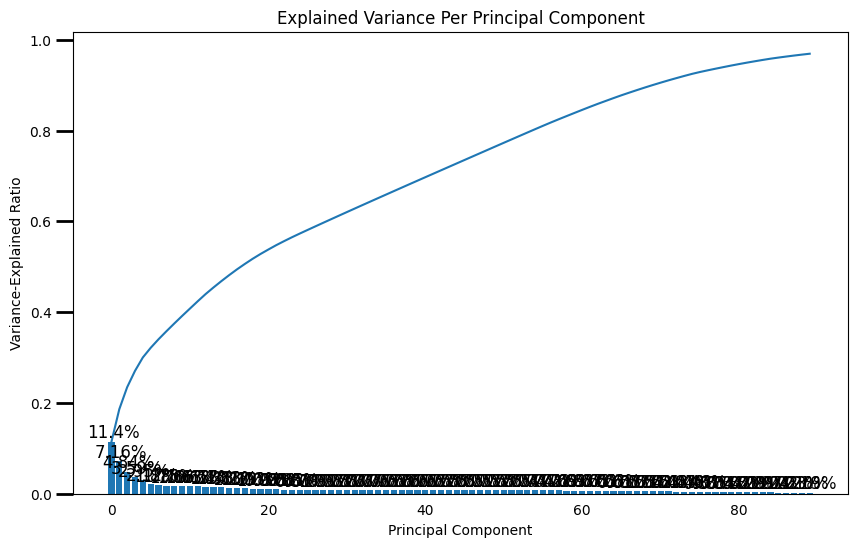

In [354]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca: PCA) -> None:
    """
    Generate a scree plot to visualize the explained variance per principal component.

    Parameters:
    pca (PCA): The PCA object containing the principal components.

    Returns:
    None
    """
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        # Perform some action for each component
        pass
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance-Explained Ratio")
    plt.title('Explained Variance Per Principal Component')


scree_plot(pca)

In [355]:
# Re-apply PCA to the data while selecting for number of components to retain.


### Discussion 2.2: Perform Dimensionality Reduction

The preprocessed azdias dataset comprises 135 columns, and according to the PCA analysis, approximately 90% of the variance can be explained by 90 components, which is roughly two-thirds of the total columns. Hence, we opt to retain these 90 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

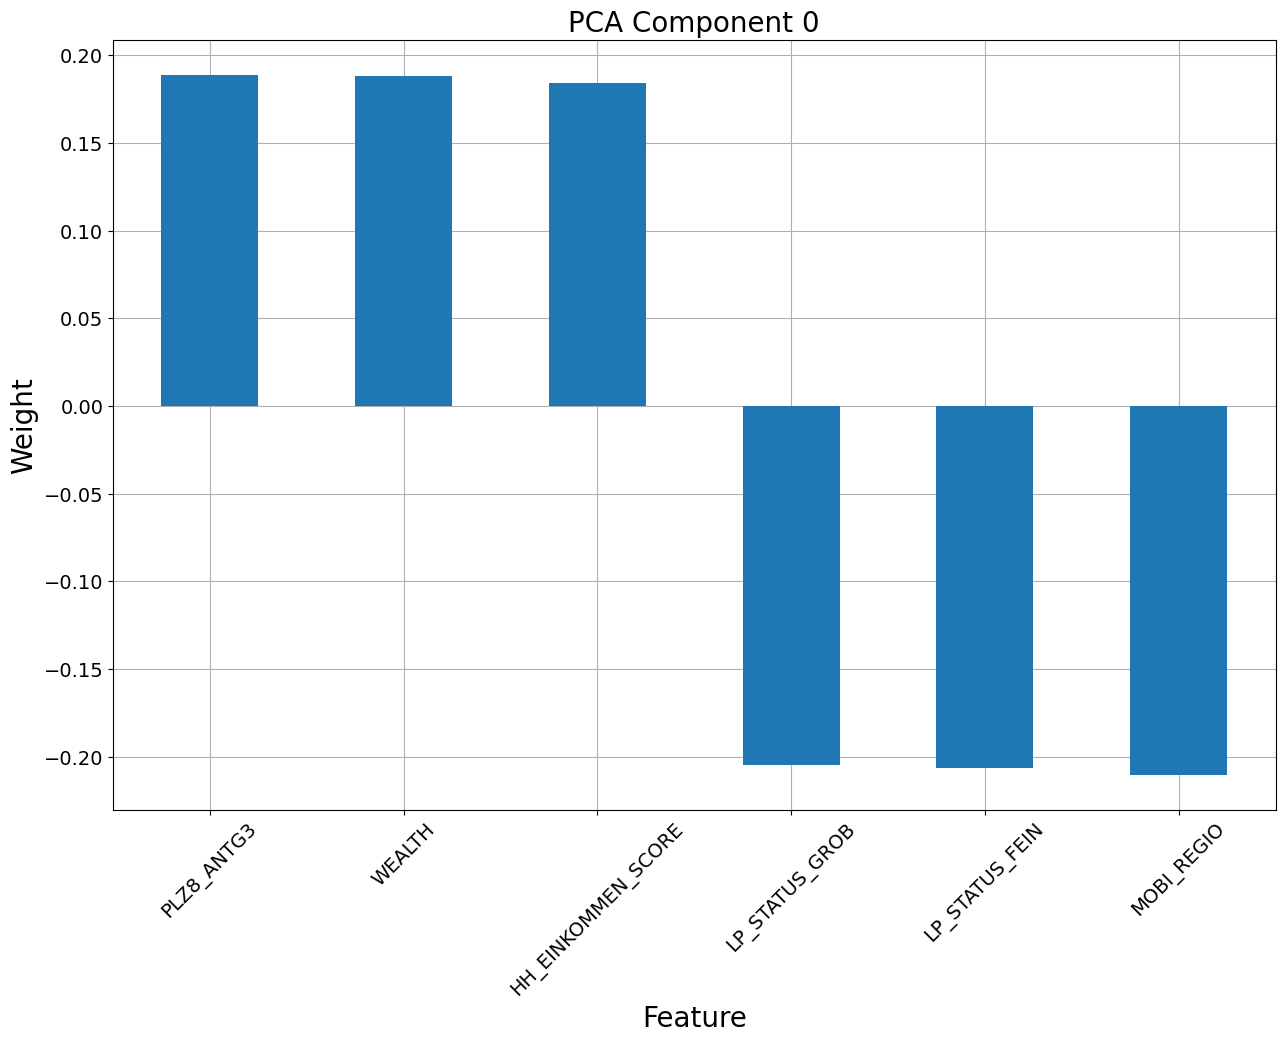

In [356]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weights(pca: PCA, i: int) -> pd.Series:
    """
    Calculate the weights of the principal component analysis (PCA) for a given component index.

    Parameters:
    pca (PCA): The PCA object.
    i (int): The index of the component.

    Returns:
    pd.Series: The weights of the PCA component, sorted in descending order.
    """
    df = pd.DataFrame(pca.components_, columns=azdias.columns)
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

def plot_pca_weights(pca: PCA, i: int, j: int) -> None:
    """
    Plots the weights of the PCA components for a given pair of indices.

    Parameters:
    - pca (PCA): The PCA object.
    - i (int): The index of the PCA component.
    - j (int): The number of top and bottom weights to display.

    Returns:
    None
    """
    weights = pca_weights(pca, i)
    weights = pd.concat([weights.head(j), weights.tail(j)])
    weights.plot.bar(figsize=(15, 10), rot=45, fontsize=14)
    plt.title('PCA Component ' + str(i))
    plt.xlabel('Feature')
    plt.ylabel('Weight')
    ax = plt.gca()
    ax.grid()
    ax.set_axisbelow(True)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(20)
    plt.show()

plot_pca_weights(pca, 0, 3)

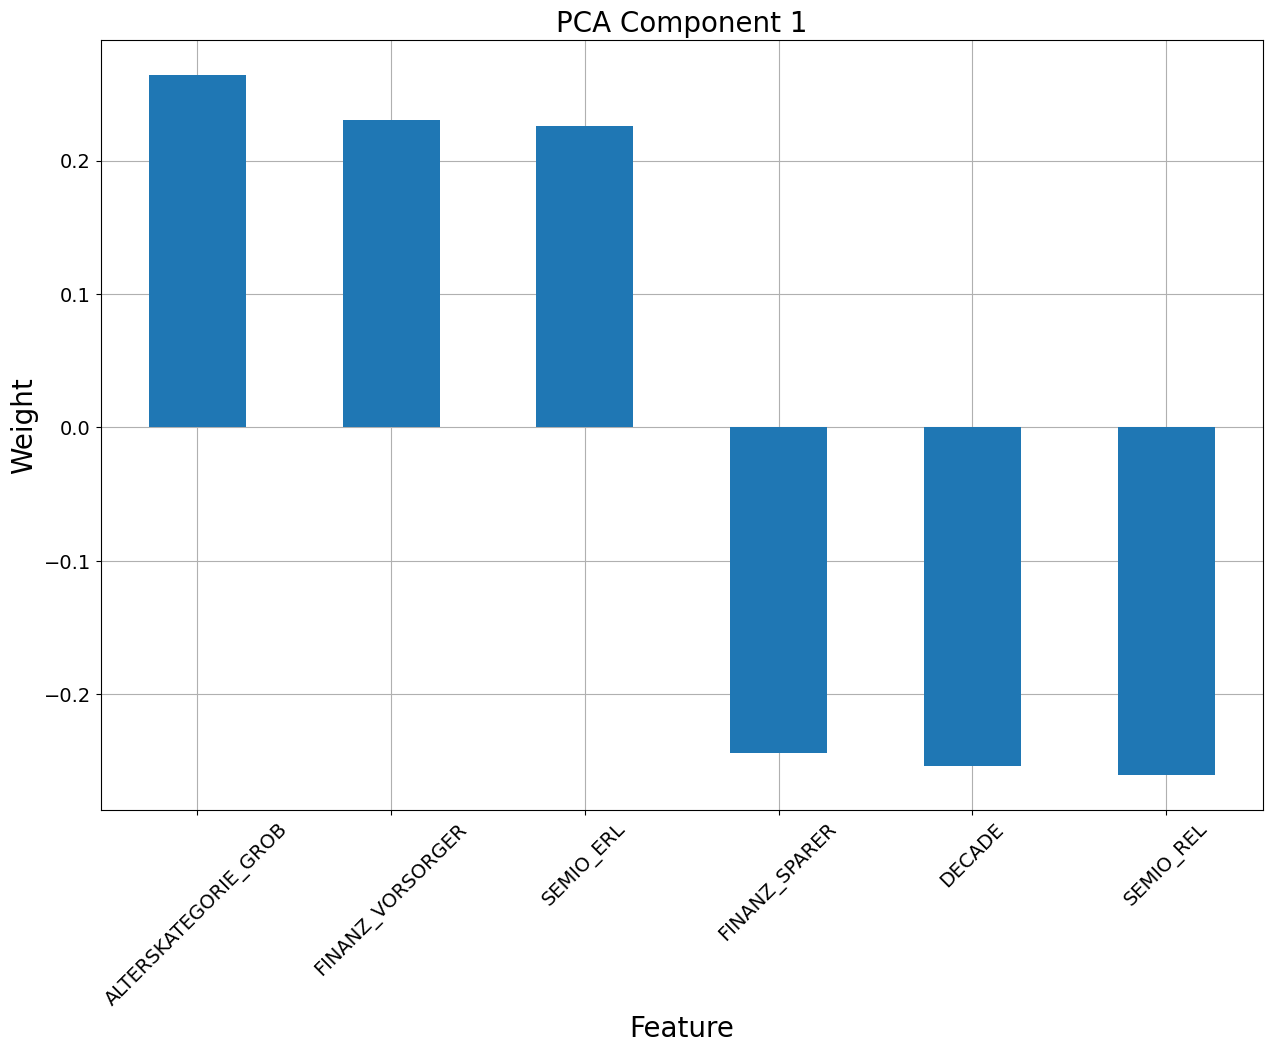

In [357]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_pca_weights(pca, 1, 3)

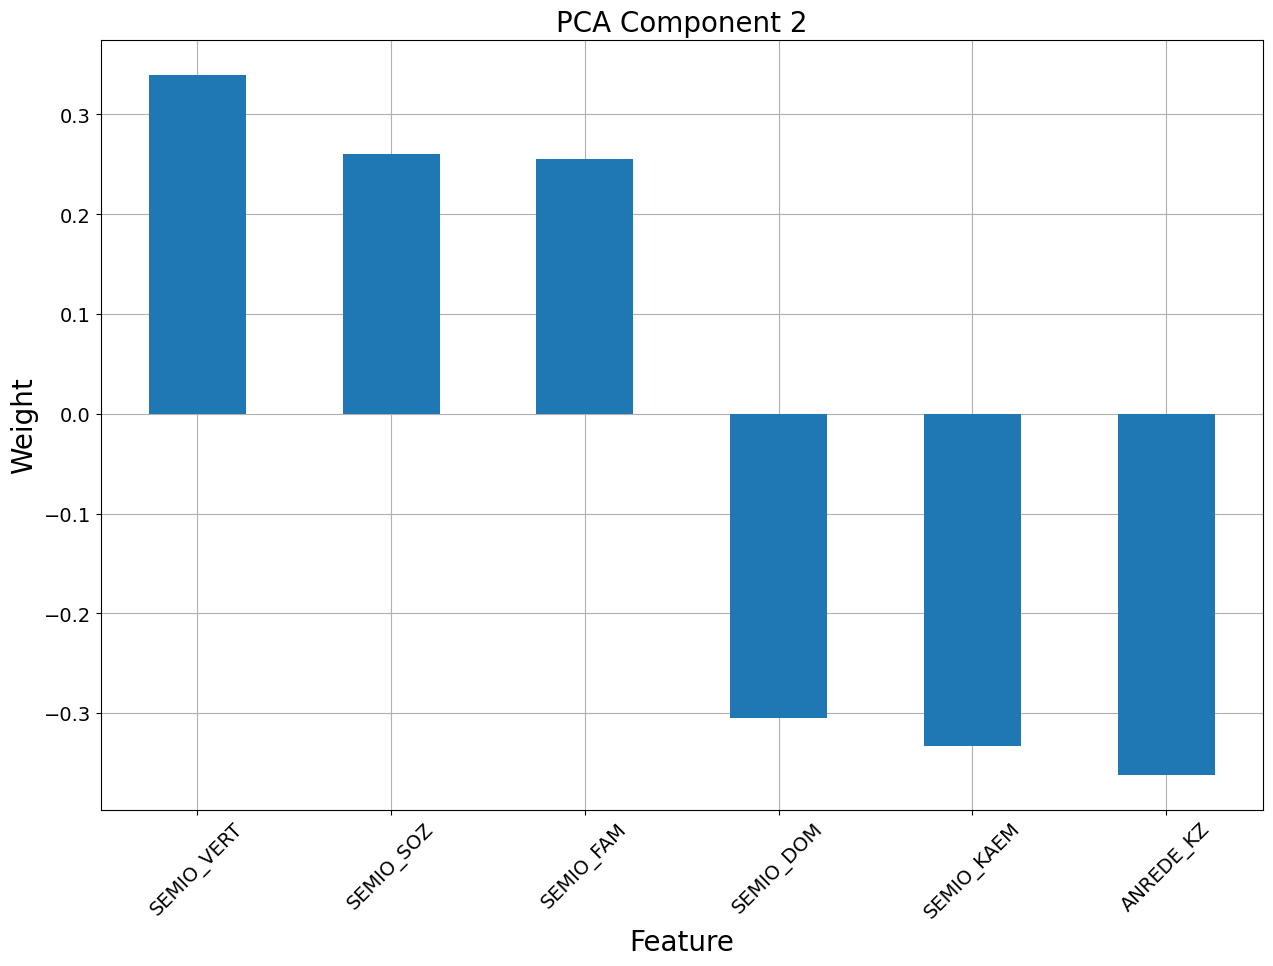

In [358]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_pca_weights(pca, 2, 3)

### Discussion 2.3: Interpret Principal Components

**First Principal Component**

The first principal component seems to capture a pattern where regions with higher numbers of 6-10 family houses, greater wealth, higher estimated household net incomes, and lower social statuses and mobility levels tend to cluster together. This pattern could be indicative of certain socio-economic characteristics or geographic distributions within the dataset. Here's a breakdown:

- **PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region)** and **WEALTH** have positive weights, indicating a positive correlation. This suggests that areas with a higher number of 6-10 family houses tend to correlate with higher levels of wealth.

- **HH_EINKOMMEN_SCORE (Estimated household net income)** also shows a positive weight, reinforcing the association between wealth and income. This suggests that areas with higher estimated household net income tend to have more 6-10 family houses in the PLZ8 region.

- **LP_STATUS_GROB (Social status, rough scale)** and **LP_STATUS_FEIN (Social status, fine scale)** exhibit negative weights. This suggests an inverse relationship between social status and the number of 6-10 family houses in the PLZ8 region. As social status decreases, the number of such houses tends to increase.

- **MOBI_REGIO (Movement patterns)** also displays a negative weight, indicating a negative correlation. This implies that areas with more dynamic movement patterns tend to have fewer 6-10 family houses in the PLZ8 region.

**Second Principal Component**

The second component seems to capture a complex mix of age-related estimations, financial behaviors, personality traits related to being event-oriented or religious, as well as historical context represented by the decade variable. These associations provide valuable insights into the underlying patterns within the dataset. Here's a breakdown:

1. **ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)**: This variable positively contributes to the second component with a weight of 0.264098. It suggests that older age groups may correlate with higher values in this component.

2. **FINANZ_VORSORGER (Financial typology, be prepared)**: With a weight of 0.230254, this feature indicates a positive association with the second component, implying that individuals with a tendency to be financially prepared tend to exhibit characteristics aligned with this component.

3. **SEMIO_ERL (Personality typology, event-oriented)**: This variable contributes positively to the second component with a weight of 0.225814, suggesting that individuals who are event-oriented tend to share similarities with this component.

4. **FINANZ_SPARER (Financial typology, money-saver)**: Contrarily, this feature has a negative weight of -0.243934, implying that individuals characterized as money-savers have an inverse relationship with the second component.

5. **DECADE**: The variable exhibits a negative weight of -0.253746, suggesting that certain time periods or decades may have an opposing influence on the second component.

6. **SEMIO_REL (Personality typology, religious)**: With a weight of -0.260539, this feature indicates a negative association with the second component, implying that individuals with religious inclinations may have characteristics that diverge from this component.

**Third Principal Component**

The third component of the principal component analysis seems to reflect a combination of personality traits related to being dreamful, socially-minded, and family-minded, while also contrasting with traits associated with dominance and combativeness. Gender also appears to play a role in shaping the characteristics represented by this component. These insights shed light on the underlying patterns and dimensions within the dataset. Here's a breakdown of the analysis:

1. **SEMIO_VERT (Personality typology, dreamful)**: This feature contributes positively to the third component with a weight of 0.340016. It suggests that individuals who exhibit dreamful personality traits are associated with higher values in this component.

2. **SEMIO_SOZ (Personality typology, socially-minded)**: With a weight of 0.260651, SEMIO_SOZ positively influences the third component, indicating that individuals characterized as socially-minded contribute to the higher values of this component.

3. **SEMIO_FAM (Personality typology, family-minded)**: Similarly, SEMIO_FAM adds to the positive direction of the third component with a weight of 0.255092, implying that individuals with family-minded tendencies are aligned with this component.

4. **SEMIO_DOM (Personality typology, dominant-minded)**: In contrast, SEMIO_DOM negatively contributes to the third component with a weight of -0.304846. This suggests that individuals with dominant-minded traits exhibit characteristics that diverge from this component.

5. **SEMIO_KAEM (Personality typology, combative attitude)**: Similarly, SEMIO_KAEM negatively influences the third component with a weight of -0.332613, indicating that individuals with a combative attitude also diverge from this component.

6. **ANREDE_KZ (Gender)**: This variable has a negative weight of -0.361714, implying that gender has an inverse relationship with the third component.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [396]:
from sklearn.cluster import KMeans

def get_kmeans_score(data: pd.DataFrame, center: int) -> float:
    """
    Calculate the average within-cluster distances for a given number of clusters using k-means clustering.

    Parameters:
    data (pd.DataFrame): The input data for clustering.
    center (int): The number of clusters.

    Returns:
    float: The average within-cluster distances.
    """
    kmeans = KMeans(n_clusters=center, n_init='auto')
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

# Over a number of different cluster counts...
scores = []
centers = list(range(1, 21))
for center in centers:
    # run k-means clustering on the data
    scores.append(get_kmeans_score(X_pca, center)) 

Text(0.5, 1.0, 'SSE vs. K')

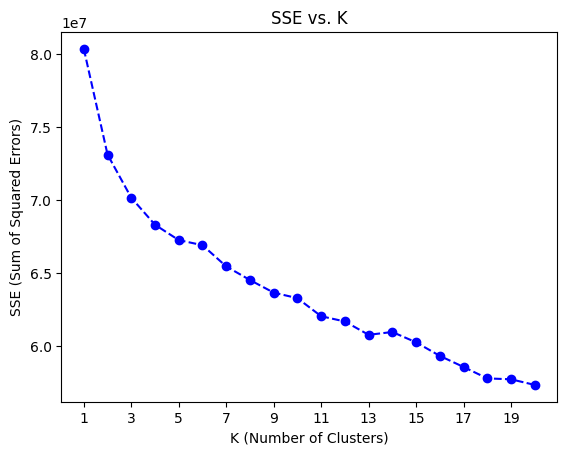

In [397]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xticks(np.arange(1, 21, 2))
plt.xlabel('K (Number of Clusters)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('SSE vs. K')

In [393]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=4, n_init='auto')
model = kmeans.fit(X_pca)
azdias['cluster'] = model.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

I observed a subtle change in slope at 4, so it seems appropriate to group the data using four clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [394]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [395]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = clean_data(customers)

customers = customers.dropna()

# scaler = StandardScaler()
# scaled_array = scaler.fit_transform(customers)
scaled_array = scaler.transform(customers)
customers = pd.DataFrame(scaled_array, columns = customers.columns, index = customers.index)

_, X_pca_customers = do_pca(components, customers)

# kmeans = KMeans(n_clusters=3, n_init='auto')
# model = kmeans.fit(X_pca_customers)
customers['cluster'] = model.predict(X_pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

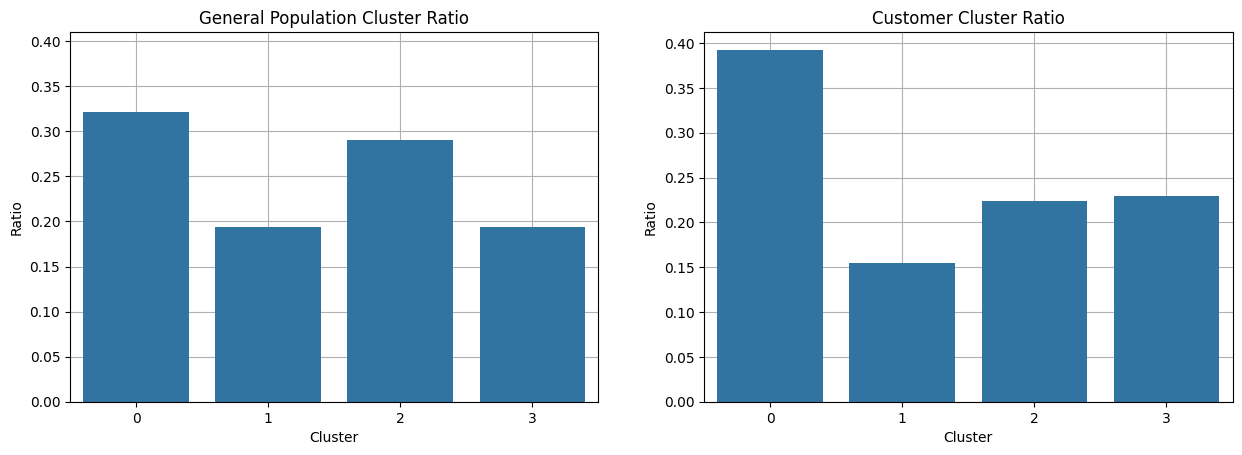

In [413]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)

sns.barplot(azdias['cluster'].value_counts() / len(azdias), ax=ax1)
ax1.set_title('General Population Cluster Ratio')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Ratio')
ax1.grid()
ax1.set_axisbelow(True)
ax1.set_ylim(0, 0.41)

sns.barplot(customers['cluster'].value_counts() / len(customers), ax=ax2)
ax2.set_title('Customer Cluster Ratio')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Ratio')
ax2.grid()
ax2.set_axisbelow(True)
ax1.set_ylim(0, 0.41)

plt.show()

In [447]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_0 = pca.inverse_transform(model.cluster_centers_[0].reshape(1, -1))

for feature, value in zip(customers.columns, centroid_0[0]):
    print(f"{feature}: {value}")

ALTERSKATEGORIE_GROB: 0.6234736294399786
ANREDE_KZ: -0.03684733284968651
CJT_GESAMTTYP: -0.2659705001093162
FINANZ_MINIMALIST: 0.9860864164898135
FINANZ_SPARER: -0.7222929055158702
FINANZ_VORSORGER: 0.5897871585232275
FINANZ_ANLEGER: -0.44413174615408774
FINANZ_UNAUFFAELLIGER: -0.4568899415703169
FINANZ_HAUSBAUER: -0.6161477567677578
FINANZTYP: 0.2897969942683354
GFK_URLAUBERTYP: -0.27224868143318887
GREEN_AVANTGARDE: 0.5215180554164014
HEALTH_TYP: -0.09731232426199467
LP_LEBENSPHASE_FEIN: 0.5544959882418797
LP_LEBENSPHASE_GROB: 0.48139478488348136
LP_FAMILIE_FEIN: 0.2725073754095501
LP_FAMILIE_GROB: 0.2802470094920943
LP_STATUS_FEIN: 0.9909232048557185
LP_STATUS_GROB: 1.0050801198300576
NATIONALITAET_KZ: -0.25699013338734045
RETOURTYP_BK_S: 0.1614257544112353
SEMIO_SOZ: -0.1777600189084895
SEMIO_FAM: -0.36793367440354474
SEMIO_REL: -0.54365264459046
SEMIO_MAT: -0.4687885055389588
SEMIO_VERT: 0.14066667814751607
SEMIO_LUST: 0.4128159723550637
SEMIO_ERL: 0.40572110999684957
SEMIO_KULT: 

In [446]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_2 = pca.inverse_transform(model.cluster_centers_[2].reshape(1, -1))

for feature, value in zip(customers.columns, centroid_2[0]):
    print(f"{feature}: {value}")


ALTERSKATEGORIE_GROB: 3.442234912107963
ANREDE_KZ: 1.5383025091542928
CJT_GESAMTTYP: 3.1363350861855466
FINANZ_MINIMALIST: 2.834231805325334
FINANZ_SPARER: 1.9634263071519613
FINANZ_VORSORGER: 4.211524452734768
FINANZ_ANLEGER: 2.0068739979029724
FINANZ_UNAUFFAELLIGER: 1.6930686202651453
FINANZ_HAUSBAUER: 3.962481497304058
FINANZTYP: 4.741491831848814
GFK_URLAUBERTYP: 7.443264287933559
GREEN_AVANTGARDE: 0.08348937201521259
HEALTH_TYP: 2.197381217702584
LP_LEBENSPHASE_FEIN: 11.612320556214428
LP_LEBENSPHASE_GROB: 3.5972638055048654
LP_FAMILIE_FEIN: 2.630464015406533
LP_FAMILIE_GROB: 1.8113689476549406
LP_STATUS_FEIN: 2.1969377377315378
LP_STATUS_GROB: 1.4613249653488762
NATIONALITAET_KZ: 1.1009780174649961
RETOURTYP_BK_S: 4.284115320946119
SEMIO_SOZ: 3.9982774883237235
SEMIO_FAM: 3.474336183418938
SEMIO_REL: 2.7673579428103903
SEMIO_MAT: 3.2885354166124365
SEMIO_VERT: 4.124155878138415
SEMIO_LUST: 5.175556185900468
SEMIO_ERL: 5.4345195064073355
SEMIO_KULT: 3.3372738504936095
SEMIO_RAT: 3

### Discussion 3.3: Comparing Customer Data with Demographics Data

In this analysis, Cluster 0 emerges as the most significantly overrepresented group compared to the general demographic data, while Cluster 2 stands out as the most notably underrepresented cluster.

#### Overrepresented Cluster 0

Cluster 0 appears to consist primarily of older individuals with diverse financial behaviors and social statuses. They exhibit a blend of personality traits associated with specific residential environments, financial situations, mobility patterns, and generational influences. Understanding this cluster provides valuable insights into the characteristics and preferences of the individuals within it within the context of our dataset. Here's a breakdown of the key attributes:

1. **Age Distribution (ALTERSKATEGORIE_GROB)**: Individuals in this cluster tend to be older, reflecting a mature demographic.

2. **Financial Behavior (FINANZ_...)**: The cluster demonstrates varied financial inclinations, encompassing conservatism, cautiousness, and investment interests.

3. **Social Status (LP_STATUS_FEIN, LP_STATUS_GROB)**: Members of this cluster exhibit relatively higher social status indicators.

4. **Personality Traits (SEMIO_...)**: The cluster displays a mix of personality traits, with lower values for traditional, religious, and dominant traits while showing higher values for sensual-mindedness and cultural-mindedness.

5. **Residential Characteristics (PLZ8_...)**: Individuals in this cluster likely reside in areas with higher density and more moderate to low-density family homes.

6. **Financial Status (HH_EINKOMMEN_SCORE, WEALTH)**: The cluster tends to have lower estimated household net income and overall wealth.

7. **Mobility Patterns (MOBI_REGIO)**: Higher mobility is observed among individuals in this cluster, possibly indicating residence in areas with a more mobile population.

8. **Generational Influence (DECADE)**: Members of this cluster may be associated with particular decades, suggesting generational influences.

9. **Life Stage (LIFE_STAGE)**: The cluster comprises individuals in various life stages, with a slight inclination towards certain stages.

#### Underrepresented Cluster 2

Cluster 2 represents a diverse group of individuals with moderate to higher financial stability, moderate social status, and varied personality traits and housing characteristics. They are typically middle-aged or older, with a slight male predominance. Financially, they exhibit a mix of preparedness, investment inclination, and minimalistic tendencies. Their lifestyle and neighborhood characteristics suggest a blend of urban and rural settings with moderate mobility patterns. Let's delve deeper into the components defining this cluster:

1. **Age Range (ALTERSKATEGORIE_GROB)**: Individuals in this cluster span a mix of middle-aged and older demographics.

2. **Gender Distribution (ANREDE_KZ)**: This cluster has a slight skew towards males.

3. **Financial Behavior (FINANZ_...)**: The cluster displays a range of financial tendencies, including moderate to high-interest levels, preparedness, and investment inclination.

4. **Social Status and Lifestyle (LP_STATUS_FEIN, LP_FAMILIE_FEIN, LP_LEBENSPHASE_FEIN)**: Social status indicators and family structures within this cluster tend to be moderate to lower in scale.

5. **Personality Traits (SEMIO_...)**: A mixture of personality traits characterizes this cluster, encompassing social, family-oriented, religious, and dominant characteristics.

6. **Housing and Neighborhood Features (PLZ8_...)**: Diversity in housing types and neighborhood characteristics is observed, reflecting a blend of urban and rural environments.

7. **Income and Wealth Indicators (HH_EINKOMMEN_SCORE, WEALTH)**: Individuals within this cluster tend to have higher estimated household net incomes and overall wealth.

8. **Mobility and Transportation (MOBI_REGIO, KONSUMNAEHE, REGIOTYP)**: Mobility patterns suggest moderate mobility and proximity to shopping facilities.

9. **Other Factors**: The cluster embodies a mix of demographic and lifestyle attributes, including family size, regional characteristics, and historical context represented by the decade variable.

Understanding these clusters provides valuable insights into the diverse characteristics and preferences of the individuals within our dataset, enabling us to make informed analyses and decisions.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.